# Прогнозирование уровня средней заработной платы в России

Имеются данные о изменении среднего уровня заработной платы в России с 01.01.1993 по 01.07.2019.Нужно пронализировать соответсвующий временной ряд и сделать предсказания о изменении среднего уровня зарплаты в будущем.

In [48]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product


Populating the interactive namespace from numpy and matplotlib


/Users/irinaskripka/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [49]:
data = pd.read_csv('zp.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [50]:
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


### Визуальный анализ ряда.

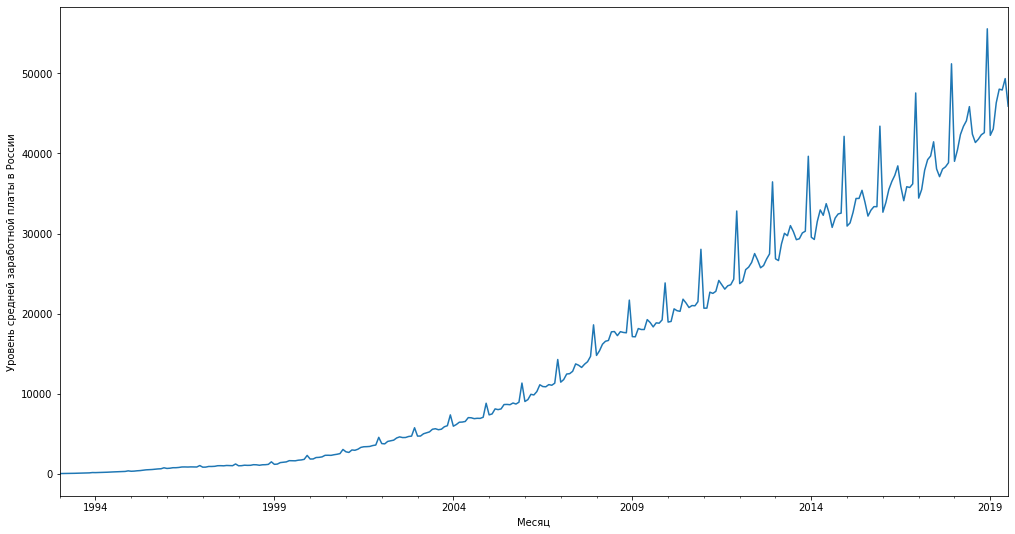

In [51]:
plt.figure(figsize(17,9))
data.WAG_C_M.plot()
plt.ylabel(u'Уровень средней заработной платы в России')
plt.xlabel(u'Месяц')
pylab.show()

На графике видны ярко выраженные тренд и сезонность, с каждым годом уровень средней заработной платы возрастает. При этом примерно до 2008 года тренд можно описать скорее как квадратичный, так как заметна некоторая выпуклость ряда. Начиная с 2009 зависимость скорее линейная. Так же имеет место меняющаяся во времени дисперсия. Отсечем от данных все, что ранее 2009, так как прогнозировать нужно будущее.

In [52]:
data = data[data.index >= pd.to_datetime('1/1/2009')]

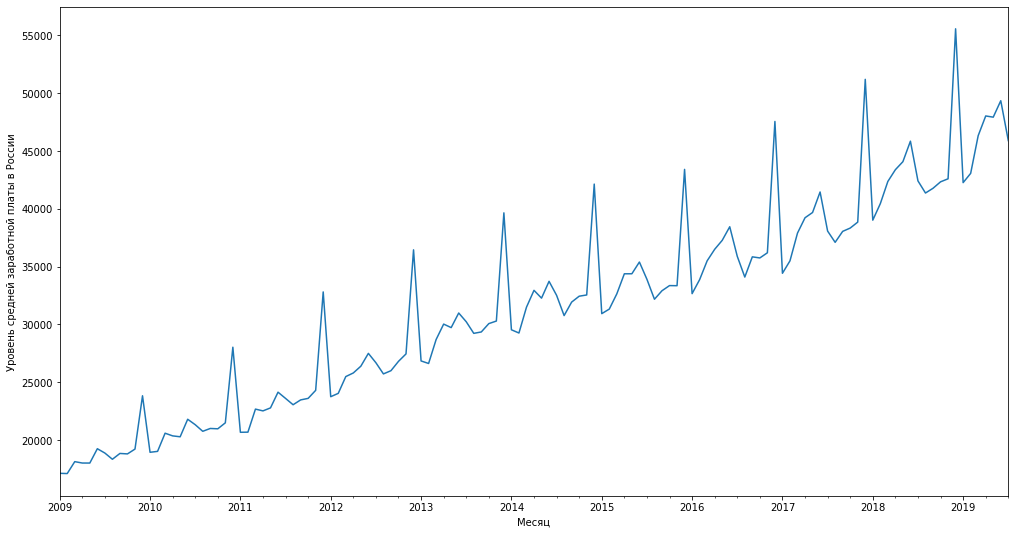

In [53]:
plt.figure(figsize(17,9))
data.WAG_C_M.plot()
plt.ylabel(u'Уровень средней заработной платы в России')
plt.xlabel(u'Месяц')
pylab.show()

Теперь линейный тренд на графике становится ещё более заметным.

### Приведение к стационарности.

Критерий Дики-Фуллера: p=0.991220


<Figure size 1080x720 with 0 Axes>

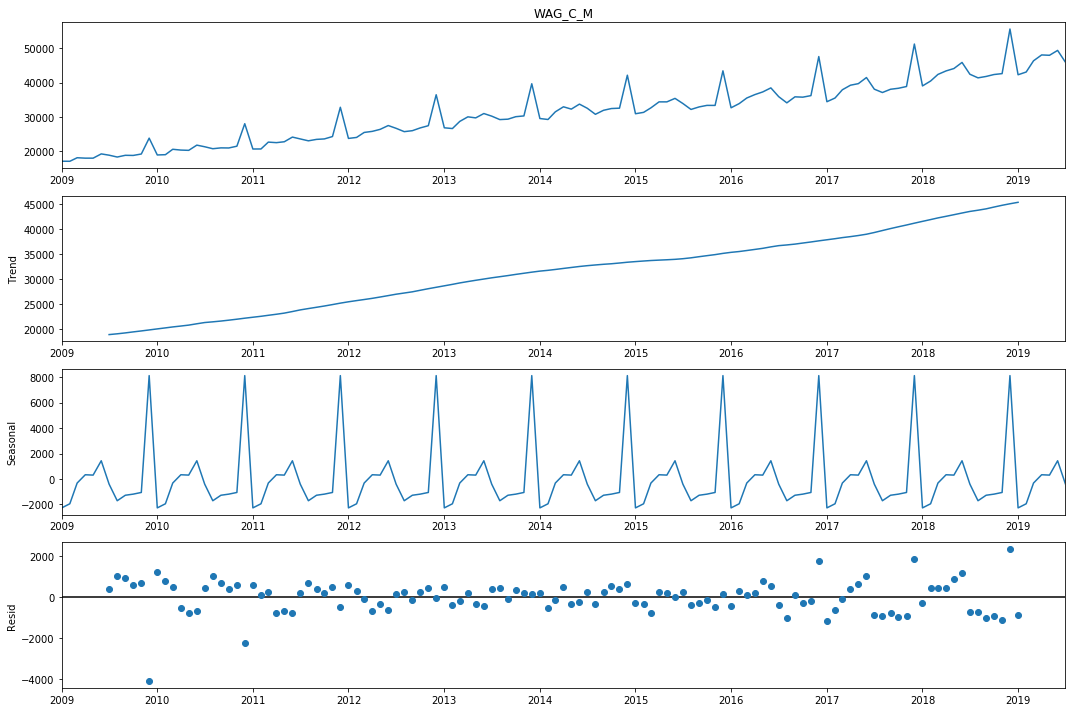

In [54]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])
plt.show()

Критерий Дики-Фуллера даёт достигаемый уровень значимости $p = 0.991220$, что говорит о нестационарности ряда, но это очевидно было и без него.

Стабилизируем дисперсию ряда с помощью преобразования Бокса-Кокса.

Оптимальный параметр преобразования Бокса-Кокса: 0.391727
Критерий Дики-Фуллера: p=0.776909


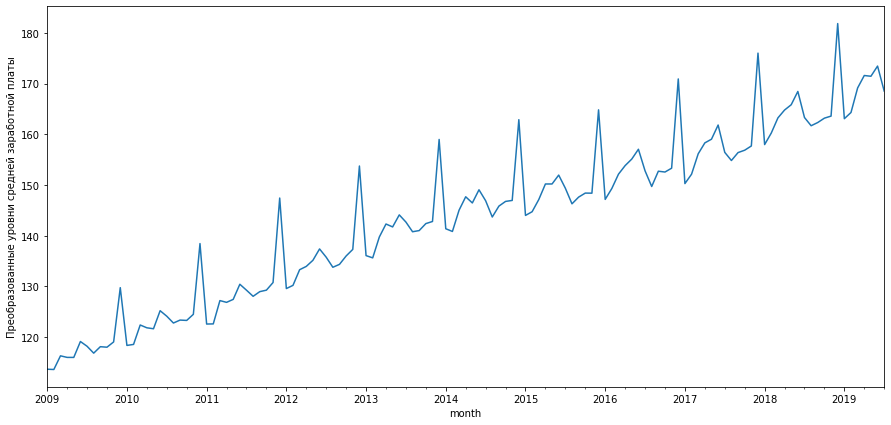

In [55]:
data['WAG_C_M_box'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.WAG_C_M_box.plot()
plt.ylabel(u'Преобразованные уровни средней заработной платы')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box)[1])

 Критерий Дики-Фуллера по-прежнему не отвергает гипотезу о нестационарности с достаточно высоким p-value, ведь у ряда всё ещё ярко выраженный тренд.Поэтому применим к нему сначала сезонное дифференцирование.

Критерий Дики-Фуллера: p=0.160214


<Figure size 1080x720 with 0 Axes>

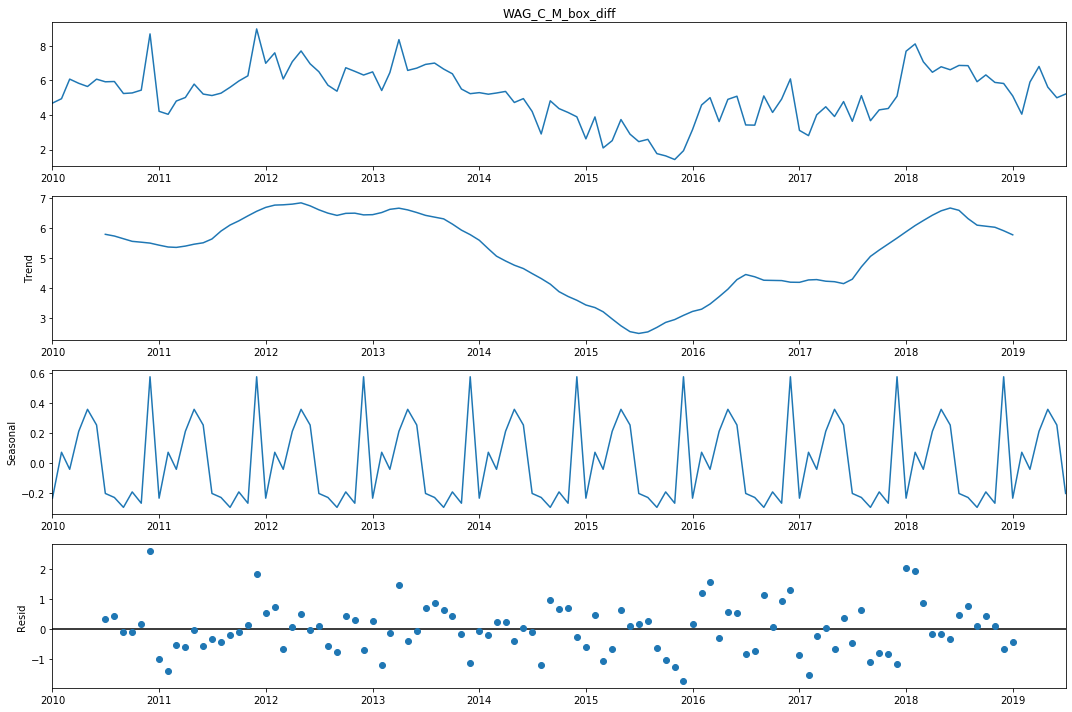

In [56]:
data['WAG_C_M_box_diff'] = data.WAG_C_M_box - data.WAG_C_M_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff[12:])[1])

 Ряд всё ещё нестационарный. Критерий Дики-Фуллера имеет $p = 0.160214$. Проводим дифференцирование ряда ещё раз.

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

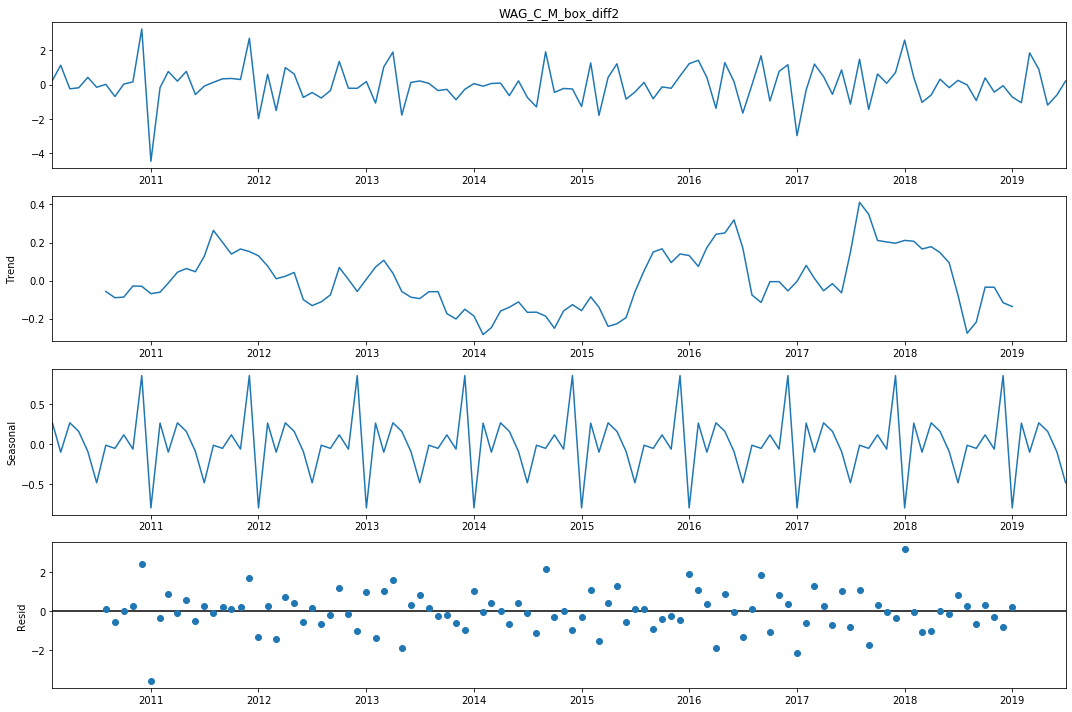

In [57]:
data['WAG_C_M_box_diff2'] = data.WAG_C_M_box_diff - data.WAG_C_M_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff2[13:])[1])

На этот раз критерий Дики-Фуллера уверенно отвергает гипотезу о нестационарности ряда.

### Построим и проанализируем кореллограммы.

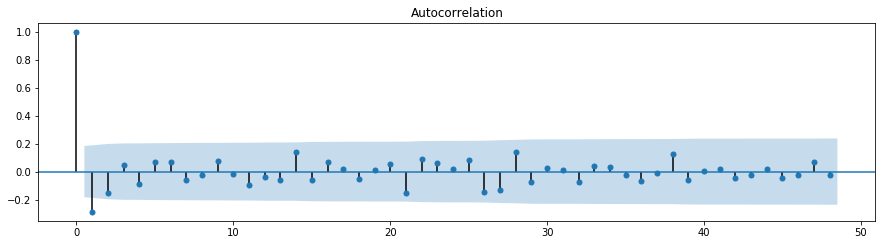

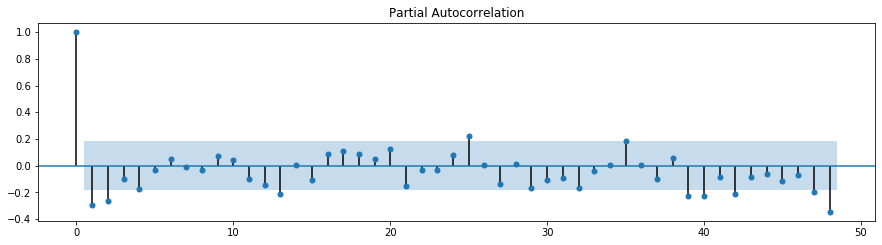

In [58]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: $Q = 0, q = 1, P = 4, p = 4$

In [59]:
ps = range(0, 5)
d=1
qs = range(0, 2)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

In [60]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

50

### Обучение модели

In [71]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 1min 5s, sys: 1.66 s, total: 1min 7s
Wall time: 35.5 s


In [62]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
15  (1, 1, 0, 0)  325.909154
5   (0, 1, 0, 0)  326.193346
6   (0, 1, 1, 0)  326.465336
16  (1, 1, 1, 0)  326.796220
25  (2, 1, 0, 0)  327.279265


In [63]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         WAG_C_M_box   No. Observations:                  127
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -159.955
Date:                             Sun, 12 Apr 2020   AIC                            325.909
Time:                                     23:53:48   BIC                            334.118
Sample:                                 01-01-2009   HQIC                           329.241
                                      - 07-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2595      0.179      1.451      0.147      -0.091       0.610
ma.L1         -0.6842      

### Проанализируем остатки полученной модели.

Критерий Стьюдента: p=0.896524
Критерий Дики-Фуллера: p=0.000000


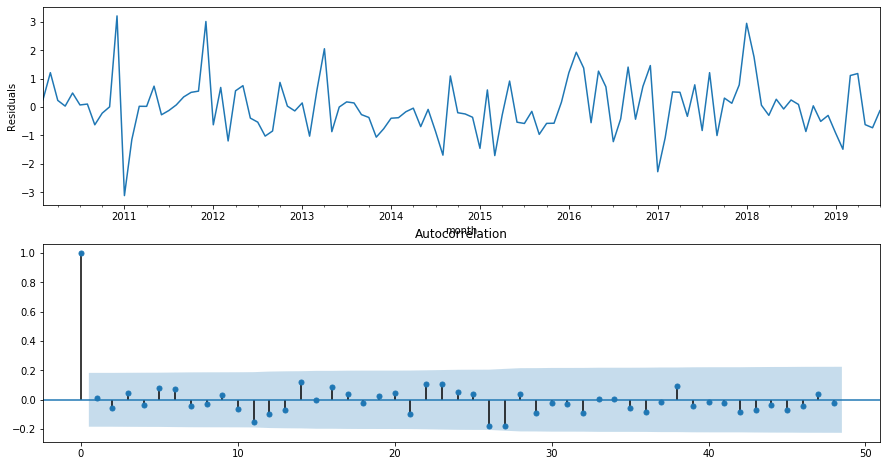

In [69]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Модель стационарна и не содержит автокорреляции, остатки несмещенные, в среднем равны 0. Следовательно, никаких поправок вносить не требуется.

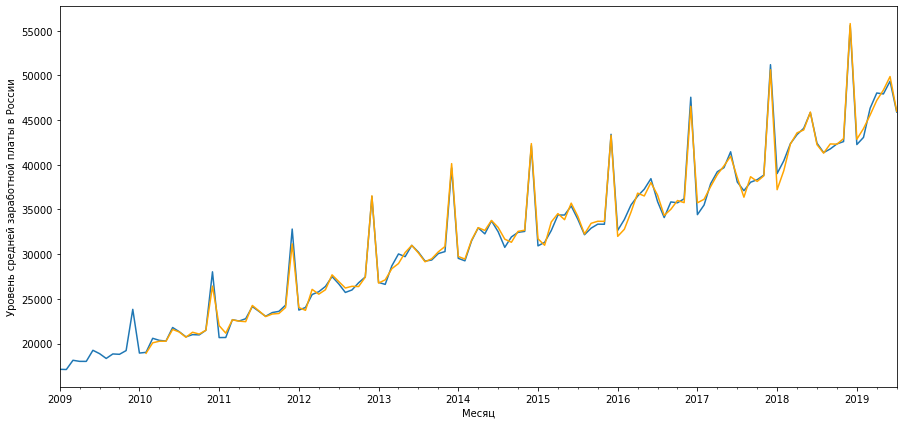

In [74]:
if lmbda == 0:
    data['model'] = np.exp(best_model.fittedvalues)
else:
    data['model'] = np.exp(np.log(lmbda*best_model.fittedvalues+1)/lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='orange')
plt.ylabel(u'Уровень средней заработной платы в России')
plt.xlabel(u'Месяц')
pylab.show()

Видем, что полученная модель как бы "лежит на графике".

Посмотрим какая сейчас зп.

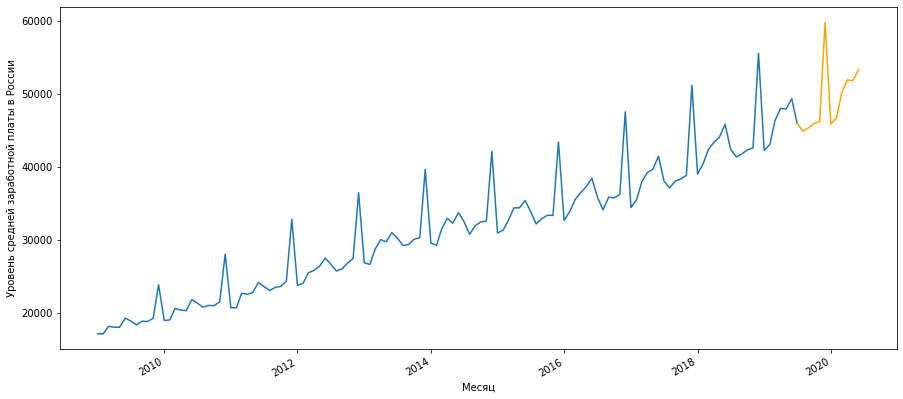

In [77]:
data_with_pred = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2019-07-01", "%Y-%m-%d") + relativedelta(months = x) for x in range(0,12)]
future = pd.DataFrame(index = date_list, columns = data_with_pred.columns)
data_with_pred = pd.concat([data_with_pred, future])
if lmbda == 0:
    data_with_pred['forecast'] = np.exp(best_model.predict(start=126, end=162))
else:
    data_with_pred['forecast'] = np.exp(np.log(lmbda*best_model.predict(start=126, end=162)+1)/lmbda)

plt.figure(figsize(15,7))
data_with_pred.WAG_C_M.plot()
data_with_pred.forecast.plot(color='orange')
plt.ylabel(u'Уровень средней заработной платы в России')
plt.xlabel(u'Месяц')
pylab.show()

Посмотрев в интернете, нашла информацию, что средняя зарплата на 01.12.2019 62239р. Предсказания не опроверглись.Посмотрим на ближайшие 2 года.

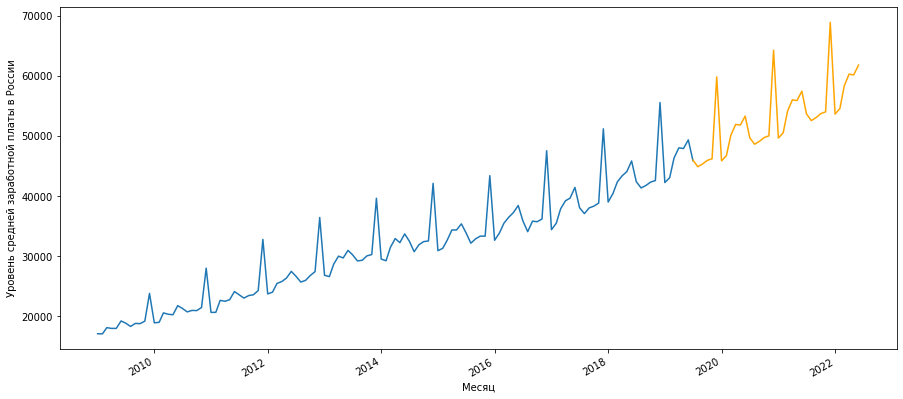

In [79]:
data_with_pred = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2019-07-01", "%Y-%m-%d") + relativedelta(months = x) for x in range(0,36)]
future = pd.DataFrame(index = date_list, columns = data_with_pred.columns)
data_with_pred = pd.concat([data_with_pred, future])
if lmbda == 0:
    data_with_pred['forecast'] = np.exp(best_model.predict(start=126, end=162))
else:
    data_with_pred['forecast'] = np.exp(np.log(lmbda*best_model.predict(start=126, end=162)+1)/lmbda)

plt.figure(figsize(15,7))
data_with_pred.WAG_C_M.plot()
data_with_pred.forecast.plot(color='orange')
plt.ylabel(u'Уровень средней заработной платы в России')
plt.xlabel(u'Месяц')
pylab.show()

Пик роста заработной платы в году приходится обычно на декабрь, так же заметен менее выраженный пик в период май-июнь. Скорее всего это связано с выплатой отпускных.